<a href="https://colab.research.google.com/github/jwang44/Plucking-Style-Detection/blob/main/Pitch_onset_preliminary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparation

In [ ]:
!pip install essentia
# !pip install pydub

In [28]:
import numpy as np
import pickle
import glob, os

import IPython
import matplotlib.pyplot as plt  
plt.rcParams['figure.figsize'] = (8, 4)

import essentia
from essentia.standard import *

import xml.etree.ElementTree as ET
# from pydub import AudioSegment

## Load a audio file to transcribe

In [6]:
def onset_detection(audio, framesize=1024, hopsize=512):
  od = OnsetDetection(method='hfc')
  w = Windowing(type = 'hann')
  fft = FFT() # this gives us a complex FFT
  c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
  pool = essentia.Pool()

  for frame in FrameGenerator(audio, frameSize = framesize, hopSize = hopsize):
      mag, phase, = c2p(fft(w(frame)))
      pool.add('features.hfc', od(mag, phase))

  onsets = Onsets()
  onsets_hfc = onsets(essentia.array([ pool['features.hfc'] ]), [1])
  return onsets_hfc

In [14]:
AUDIO_FILE = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset3/audio/promenade_mono.wav'
# ANNO_FILE = os.path.basename(AUDIO_FILE).split
SR = 44100
audio = MonoLoader(filename=AUDIO_FILE)()
onsets = onset_detection(audio)

In [29]:
IPython.display.Audio(AUDIO_FILE)

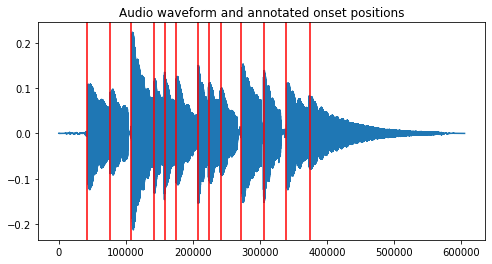

In [15]:
plt.plot(audio)
for onset in onsets:
    plt.axvline(x=onset*SR, color='red')

plt.title("Audio waveform and annotated onset positions")
plt.show()

In [18]:
def pitch_detection(audio):
  mp = MultiPitchKlapuri()
  freqs = mp(audio) # this is a list of arrays
  notes = []
  for freq_array in freqs:
    note_array = 12*np.log2(freq_array/440)+69
    note_array = np.round(note_array)
    note_tuple = tuple(note_array)
    notes.append(note_tuple)
  pitch_pred = max(set(notes), key=notes.count)
  return pitch_pred

In [31]:
pitches = []
for i in range(len(onsets)):
  onset = onsets[i]
  try:
    next_onset = onsets[i+1]
  except:
    next_onset = len(audio)/SR
  note_audio = audio[round(onset*SR):round(next_onset*SR)]
  pitch = pitch_detection(note_audio)
  pitches.append(pitch)

In [34]:
onsets

array([0.95201814, 1.7414966 , 2.4497051 , 3.2159636 , 3.575873  ,
       3.9706123 , 4.7020407 , 5.06195   , 5.4682994 , 6.141678  ,
       6.9195466 , 7.674195  , 8.475284  ], dtype=float32)

In [32]:
pitches

[(67.0, 55.0),
 (65.0, 53.0),
 (70.0, 58.0),
 (72.0, 60.0),
 (77.0, 65.0),
 (74.0,),
 (72.0, 60.0),
 (77.0,),
 (74.0,),
 (70.0, 58.0),
 (72.0,),
 (67.0, 55.0),
 (65.0, 53.0)]